In [1]:
%pylab inline
import pandas as pd
import datetime
from collections import OrderedDict
DT = datetime.datetime

Populating the interactive namespace from numpy and matplotlib


In [2]:
class PeakSearch(object):
    def __init__(self):
        fname = "north_america_rbn_filtered.csv.bz2"

        df_0 = pd.read_csv(fname,parse_dates=['datetime'])

        keys=[]
        keys.append('datetime')
        keys.append('frequency')
        keys.append('band')
        keys.append('R_gc')
        keys.append('azm')
        keys.append('call_0')
        keys.append('lat_0')
        keys.append('lon_0')
        keys.append('call_1')
        keys.append('lat_1')
        keys.append('lon_1')
        keys.append('lat_mid')
        keys.append('lon_mid')
        keys.append('srpt_0')
        #keys.append('obs_mid_300km')
        df=df_0[keys].copy()

        def ut_hr(dt):
            result = dt.hour + dt.minute/60. + dt.second/3600.
            return result
        
        df.loc[:,'ut_hr'] = df.datetime.map(ut_hr)
        
        self.df = df
        
        self.fit_list = []

    def set_calls(self,call_0,call_1,band):
        self.call_0 = call_0
        self.call_1 = call_1
        self.band   = band
        df = self.df
        
        dft=df.copy()
        tf=dft['call_0']==call_0
        dft=dft[tf]

        tf=dft['call_1']==call_1
        dft=dft[tf]

        tf=dft['band']==band
        dft=dft[tf]
        
        self.dft = dft
        self.plot_snr(marker=None)
        
    def plot_snr(self,dt_0=None,dt_1=None,marker='o'):
        call_0 = self.call_0
        call_1 = self.call_1
        band   = self.band
        
        dft    = self.dft

        xx     = dft['datetime']
        yy     = dft['srpt_0']
        
        plt.figure(figsize=(10,8))
        plt.plot(xx,yy,marker=marker)
        plt.xlim(dt_0,dt_1)
        plt.xlabel('Time(UT)')
        plt.ylabel('SNR')
        
        title = '{!s} from {!s} at {!s} MHz'.format(call_0,call_1,band)
        plt.title(title)
        plt.grid()
        plt.show()
        
    def plot_fits(self,dts,fit_0_times,fit_1_times):
        dt_0,dt_1 = dts
        call_0 = self.call_0
        call_1 = self.call_1
        band   = self.band
        dft_1  = self.dft.copy()
        dft_1  = dft_1.sort_values('datetime')

        tf    = np.logical_and(dft_1.datetime >= dt_0, dft_1.datetime < dt_1)
        dft_1 = dft_1[tf]

        dft_1 = dft_1[ ['datetime','ut_hr','srpt_0'] ]

        ######################################
        xx=dft_1['datetime']
        yy=dft_1['srpt_0']
        ut=dft_1['ut_hr']

        fit_0_tf    = np.logical_and(dft_1.datetime >= fit_0_times[0], dft_1.datetime < fit_0_times[1])
        fit_0_df    = dft_1[fit_0_tf]
        fit_0_coefs = np.polyfit(fit_0_df.ut_hr,fit_0_df.srpt_0,1)
        fit_0_dt    = fit_0_df['datetime']
        fit_0_xx    = fit_0_df.ut_hr
        fit_0_yy    = fit_0_coefs[0]*fit_0_df.ut_hr+fit_0_coefs[1]
        fit_0_label = 'Slope 0: {!s}'.format(fit_0_coefs[0])

        fit_1_tf    = np.logical_and(dft_1.datetime >= fit_1_times[0], dft_1.datetime < fit_1_times[1])
        fit_1_df    = dft_1[fit_1_tf]
        fit_1_coefs = np.polyfit(fit_1_df.ut_hr,fit_1_df.srpt_0,1)
        fit_1_dt    = fit_1_df['datetime']
        fit_1_xx    = fit_1_df.ut_hr
        fit_1_yy    = fit_1_coefs[0]*fit_1_df.ut_hr+fit_1_coefs[1]
        fit_1_label = 'Slope 1: {!s}'.format(fit_1_coefs[0])

        plt.figure(figsize=(10,8))
        plt.plot(xx,yy,marker='o')
        plt.plot(fit_0_df.datetime,fit_0_yy,ls='--',marker='o',label=fit_0_label)
        plt.plot(fit_1_df.datetime,fit_1_yy,ls='--',marker='o',label=fit_1_label)

        #plt.xlim(ut_hr(dt_0),ut_hr(dt_1))
        plt.xlim(dt_0,dt_1)

        plt.xlabel('Time(UT)')
        plt.ylabel('SNR')
        title = '{!s} from {!s} at {!s} MHz'.format(call_0,call_1,band)
        plt.title(title)
        plt.legend(loc='upper right')
        plt.grid()
        plt.show()
        
        fit_dct = OrderedDict()
        fit_dct['call_0']     = call_0
        fit_dct['call_1']     = call_1
        fit_dct['band']       = band
        fit_dct['fit_0_x']    = fit_0_dt.iloc[0]
        fit_dct['fit_0_y']    = fit_0_yy.iloc[0]
        fit_dct['fit_0_b']    = fit_0_coefs[0]
        fit_dct['fit_1_x']    = fit_1_dt.iloc[-1]
        fit_dct['fit_1_y']    = fit_1_yy.iloc[-1]
        fit_dct['fit_1_b']    = fit_1_coefs[0]
        
        self.fit_list.append(fit_dct)
    def fit_df(self):
        return pd.DataFrame(self.fit_list)

ps  = PeakSearch()

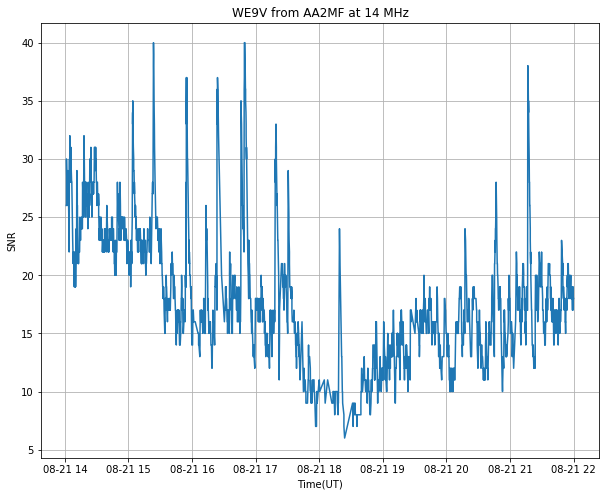

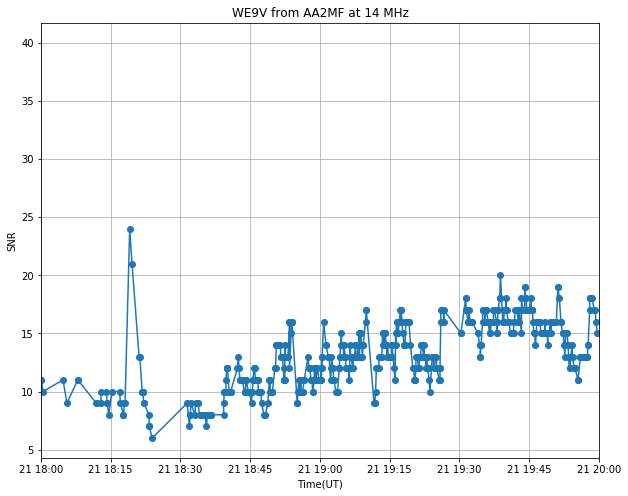

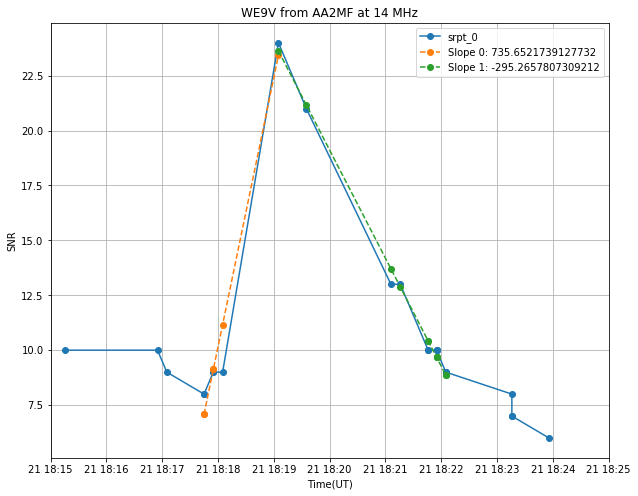

In [6]:
ps.set_calls(call_0='WE9V',call_1='AA2MF',band=14)

ps.plot_snr(DT(2017,8,21,18),DT(2017,8,21,20))

dts         = (DT(2017,8,21,18,15),   DT(2017,8,21,18,25)   )
fit_0_times = (DT(2017,8,21,18,17,45),DT(2017,8,21,18,19,10))
fit_1_times = (DT(2017,8,21,18,19),   DT(2017,8,21,18,22,30))
ps.plot_fits(dts,fit_0_times,fit_1_times)

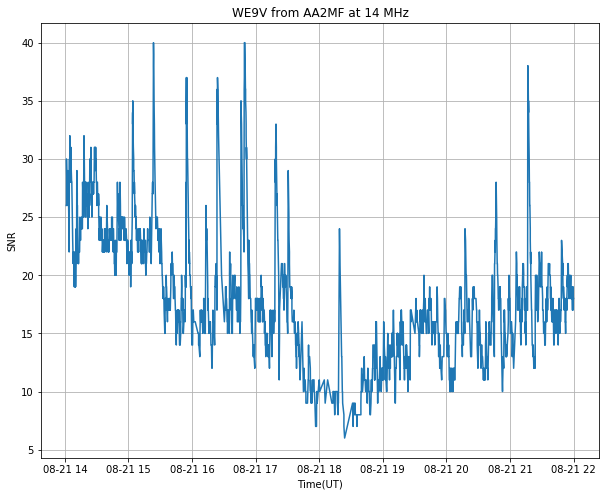

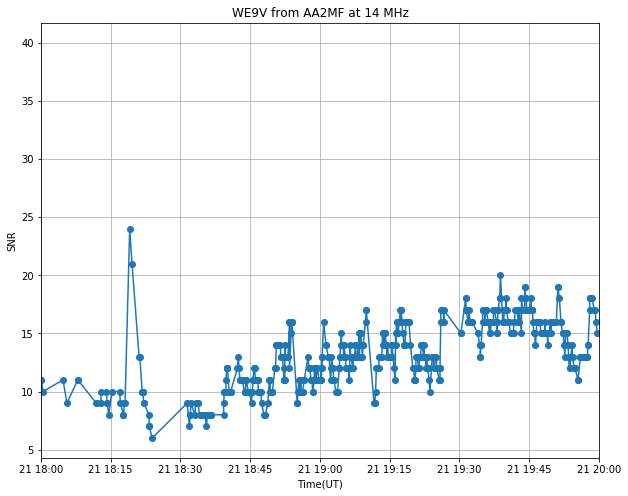

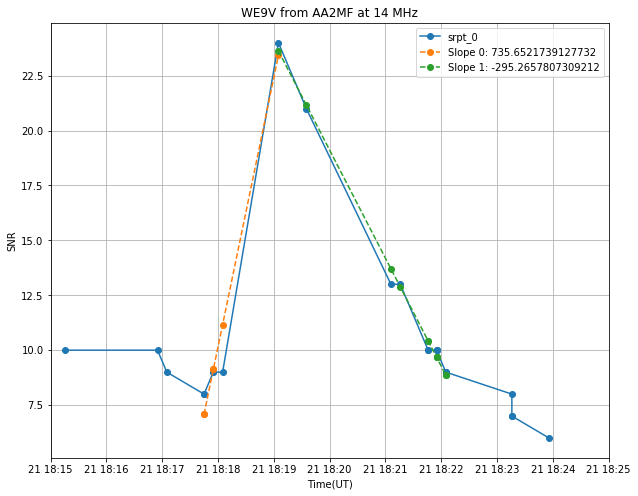

In [8]:
ps.set_calls(call_0='WE9V',call_1='AA2MF',band=14)

ps.plot_snr(DT(2017,8,21,18),DT(2017,8,21,20))

dts         = (DT(2017,8,21,18,15),   DT(2017,8,21,18,25)   )
fit_0_times = (DT(2017,8,21,18,17,45),DT(2017,8,21,18,19,10))
fit_1_times = (DT(2017,8,21,18,19),   DT(2017,8,21,18,22,30))
ps.plot_fits(dts,fit_0_times,fit_1_times)

In [10]:
ps.fit_df()

,call_0,call_1,band,fit_0_x,fit_0_y,fit_0_b,fit_1_x,fit_1_y,fit_1_b
0,WE9V,AA2MF,14,2017-08-21 18:17:45,7.07971,735.652174,2017-08-21 18:22:05,8.863523,-295.265781
1,WE9V,AA2MF,14,2017-08-21 18:17:45,7.07971,735.652174,2017-08-21 18:22:05,8.863523,-295.265781
